In this notebook, we will analyze stock data sourced from Alpha Vantage. Our workflow will include:

   1. Feature Engineering – Creating meaningful features from raw stock data to enhance our analysis and modeling.

   2. Data Visualization – Exploring trends, patterns, and relationships in the data through visualizations.

   3. Predictive Modeling – Building a model to forecast stock behavior using the engineered features.

By the end of this notebook, we aim to uncover insights from historical stock data and demonstrate a predictive approach that can inform trading or investment decisions.

In [2]:
# Connect to AlphaVantage and collect stock data
import requests
from dotenv import load_dotenv
from os import getenv

load_dotenv()
API_KEY = getenv("ALPHAVANTAGE_API_KEY")
symbol = "SPY"

url = (f"https://www.alphavantage.co/query"
        + "?function=TIME_SERIES_DAILY"
        + f"&symbol={symbol}"
        + f"&apikey={API_KEY}"
        + "&outputsize=full"  # FIXED: Uncommented to get 20+ years of data
      )

r = requests.get(url)
data = r.json()

# Add validation
if "Time Series (Daily)" in data:
    print(f"✓ Data retrieved successfully for {symbol}")
    print(f"  Date range: {list(data['Time Series (Daily)'].keys())[-1]} to {list(data['Time Series (Daily)'].keys())[0]}")
else:
    print("Error retrieving data:")
    print(data)

✓ Data retrieved successfully for SPY
  Date range: 1999-11-01 to 2025-10-24


In [3]:
# Print relevant metadata
print("DATA:         ", data.get("Meta Data").get("1. Information"))
print("SYMBOL:       ", data.get("Meta Data").get("2. Symbol"))
print("REFRESH DATE: ", data.get("Meta Data").get("3. Last Refreshed"))

DATA:          Daily Prices (open, high, low, close) and Volumes
SYMBOL:        SPY
REFRESH DATE:  2025-10-24


In [4]:
# Load data into a pandas DataFrame
import pandas as pd

df = pd.DataFrame.from_dict(data.get("Time Series (Daily)"), orient='index')
df.index.name = 'date'
df.reset_index(inplace=True)
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']

# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values('date')  # Ensure sorted by date

# Get last 5 years
three_years_ago = pd.Timestamp.now() - pd.DateOffset(years=3)
df = df[df['date'] >= three_years_ago]

print(df)

          date      open      high       low     close     volume
749 2022-10-28  379.8700  389.5200  379.6800  389.0200  100301958
748 2022-10-31  386.4400  388.4000  385.2600  386.2100   96631258
747 2022-11-01  390.1400  390.3900  383.2900  384.5200   85407598
746 2022-11-02  383.9000  388.6300  374.7600  374.8700  126990356
745 2022-11-03  371.4650  374.2000  368.7900  371.0100   87100115
..         ...       ...       ...       ...       ...        ...
4   2025-10-20  667.3200  672.2100  667.2700  671.3000   60493350
3   2025-10-21  671.4400  672.9900  669.9810  671.2900   56249034
2   2025-10-22  672.0000  672.0000  663.3000  667.8000   80564006
1   2025-10-23  668.1200  672.7101  667.8000  671.7600   65604461
0   2025-10-24  676.4600  678.4700  675.6500  677.2500   74356527

[750 rows x 6 columns]


In [5]:
# Convert columns to float
df['open'] = df['open'].astype(float)
df['close'] = df['close'].astype(float)
df['volume'] = df['volume'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)

In [6]:
import numpy as np

df["day's range"] = df['close'] - df['open']
df['price difference'] = df['high'] - df['low']
df['day to day'] = df['close'] - df['open'].shift(1)
df['log returns'] = np.log(df['close'] / df['close'].shift(1))                       

In [7]:
# Overall range
overall_range = df['close'].max() - df['open'].min()
print("Overall Open-to-Close Range:", overall_range)

Overall Open-to-Close Range: 305.785


In [8]:
df.head(2)

,date,open,high,low,close,volume,day's range,price difference,day to day,log returns
749,2022-10-28,379.87,389.52,379.68,389.02,100301958.0,9.15,9.84,NaN,NaN
748,2022-10-31,386.44,388.40,385.26,386.21,96631258.0,-0.23,3.14,6.34,-0.007249


In [9]:
# Sort by date just in case
df = df.sort_values('date')

# Day-to-day volume change
df['volume_change'] = df['volume'] - df['volume'].shift(1)

# Optional: percentage change
df['volume_pct_change'] = df['volume'].pct_change() * 100

# Calculate Price / Volume for each row (using Close price)
df['price by volume'] = df['close'] / df['volume']

In [10]:
# Initialize OBV
df['obv'] = 0

# Loop method with .loc
for i in range(1, len(df)):
    if df['close'].iloc[i] > df['close'].iloc[i-1]:
        df.loc[i, 'obv'] = df.loc[i-1, 'obv'] + df.loc[i, 'volume']
    elif df['close'].iloc[i] < df['close'].iloc[i-1]:
        df.loc[i, 'obv'] = df.loc[i-1, 'obv'] - df.loc[i, 'volume']
    else:
        df.loc[i, 'obv'] = df.loc[i-1, 'obv']

# 7-day moving average of volume
df['volume_ma7'] = df['volume'].rolling(window=7).mean()

In [11]:
df.head(2)

,date,open,high,low,close,volume,day's range,price difference,day to day,log returns,volume_change,volume_pct_change,price by volume,obv,volume_ma7
749,2022-10-28,379.87,389.52,379.68,389.02,100301958.0,9.15,9.84,NaN,NaN,NaN,NaN,0.000004,6868542567,NaN
748,2022-10-31,386.44,388.40,385.26,386.21,96631258.0,-0.23,3.14,6.34,-0.007249,-3670700.0,-3.659649,0.000004,6768240609,NaN


In [12]:
# Create lag features for close and volume
lag_days = [1, 2, 3]  # 1-day, 2-day, 3-day lags

for lag in lag_days:
    df[f'close_lag_{lag}'] = df['close'].shift(lag)
    df[f'volume_lag_{lag}'] = df['volume'].shift(lag)
    df[f'price_by_volume_lag_{lag}'] = (df['close'] * df['volume']).shift(lag)

# View result
print(df[['date', 'close', 'close_lag_1', 'close_lag_2', 'close_lag_3',
          'volume', 'volume_lag_1', 'volume_lag_2', 'volume_lag_3']])

          date   close  close_lag_1  close_lag_2  close_lag_3       volume  \
749 2022-10-28  389.02          NaN          NaN          NaN  100301958.0   
748 2022-10-31  386.21       389.02          NaN          NaN   96631258.0   
747 2022-11-01  384.52       386.21       389.02          NaN   85407598.0   
746 2022-11-02  374.87       384.52       386.21       389.02  126990356.0   
745 2022-11-03  371.01       374.87       384.52       386.21   87100115.0   
..         ...     ...          ...          ...          ...          ...   
4   2025-10-20  671.30       664.39       660.64       665.17   60493350.0   
3   2025-10-21  671.29       671.30       664.39       660.64   56249034.0   
2   2025-10-22  667.80       671.29       671.30       664.39   80564006.0   
1   2025-10-23  671.76       667.80       671.29       671.30   65604461.0   
0   2025-10-24  677.25       671.76       667.80       671.29   74356527.0   

     volume_lag_1  volume_lag_2  volume_lag_3  
749           N

                      close    volume  price by volume  log returns  \
close              1.000000 -0.366878         0.635089     0.036863   
volume            -0.366878  1.000000        -0.809670    -0.110116   
price by volume    0.635089 -0.809670         1.000000     0.094424   
log returns        0.036863 -0.110116         0.094424     1.000000   
day to day         0.039573 -0.193029         0.137778     0.714322   
volume_change      0.000967  0.422798        -0.262124    -0.162312   
volume_pct_change  0.003162  0.403557        -0.302391    -0.188109   
obv               -0.943421  0.332908        -0.605923    -0.009004   

                   day to day  volume_change  volume_pct_change       obv  
close                0.039573       0.000967           0.003162 -0.943421  
volume              -0.193029       0.422798           0.403557  0.332908  
price by volume      0.137778      -0.262124          -0.302391 -0.605923  
log returns          0.714322      -0.162312          -0

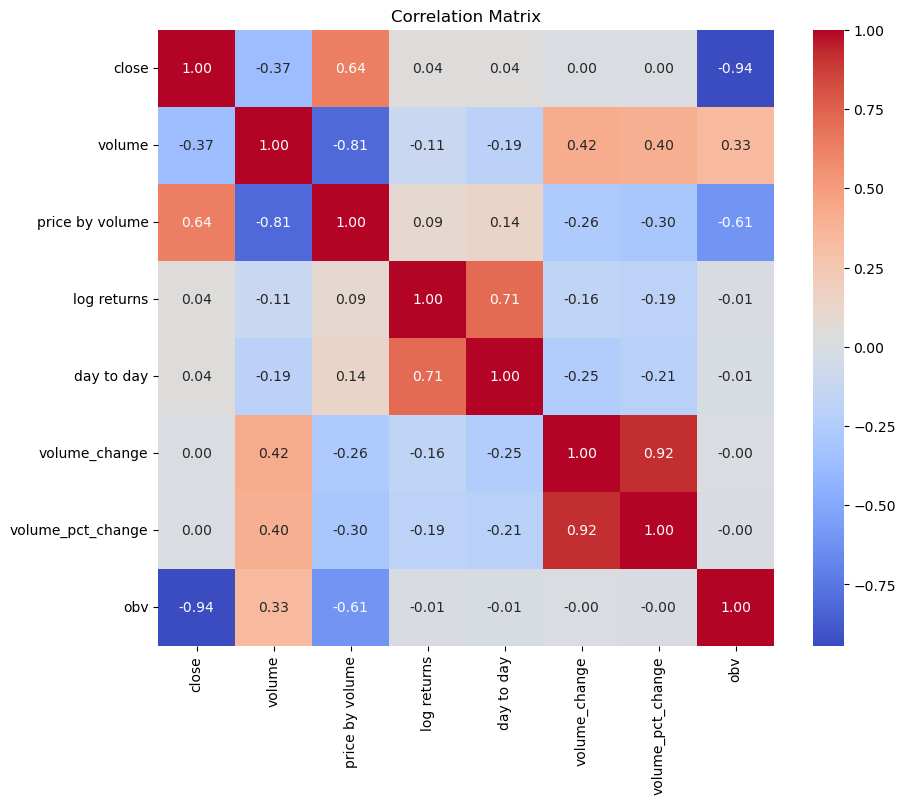

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns you want to check correlations for
numeric_cols = ['close', 'volume', 'price by volume', 'log returns', 
                'day to day', 'volume_change', 'volume_pct_change', 'obv']

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Display correlation matrix
print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

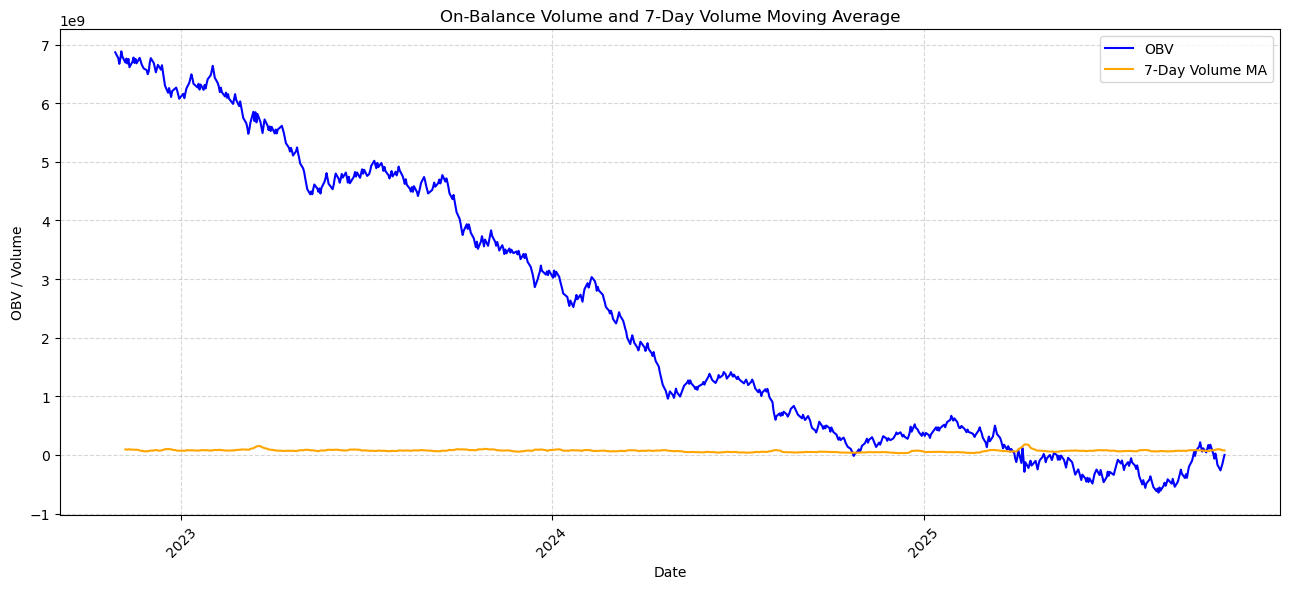

In [14]:
import matplotlib.dates as mdates

plt.figure(figsize=(13,6))

# OBV line
plt.plot(df['date'], df['obv'], color='blue', label='OBV')

# Volume moving average line
plt.plot(df['date'], df['volume_ma7'], color='orange', label='7-Day Volume MA')

# Format x-axis to show months
plt.gca().xaxis.set_major_locator(mdates.YearLocator())       # one tick per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # format as "Jan 2025", etc.

plt.xlabel('Date')
plt.ylabel('OBV / Volume')
plt.title('On-Balance Volume and 7-Day Volume Moving Average')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

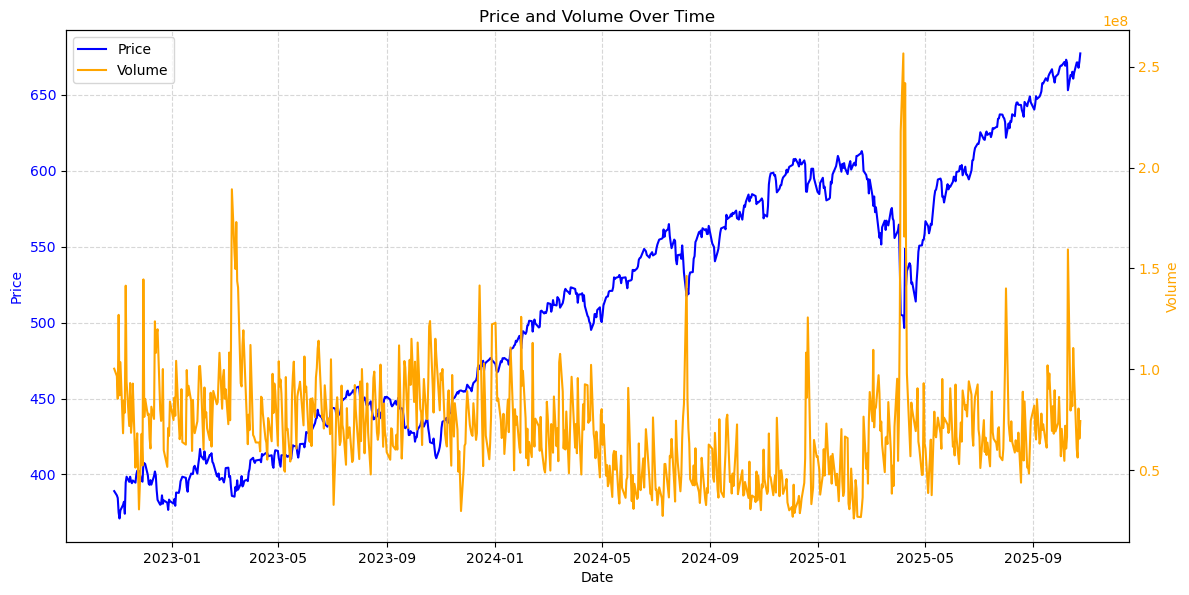

In [15]:
df['date'] = pd.to_datetime(df['date'])

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot price on left Y-axis
ax1.plot(df['date'], df['close'], color='blue', label='Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.5)

# Create second Y-axis for volume
ax2 = ax1.twinx()
ax2.plot(df['date'], df['volume'], color='orange', label='Volume')
ax2.set_ylabel('Volume', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and legend
fig.tight_layout()
plt.title('Price and Volume Over Time')

# Show combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

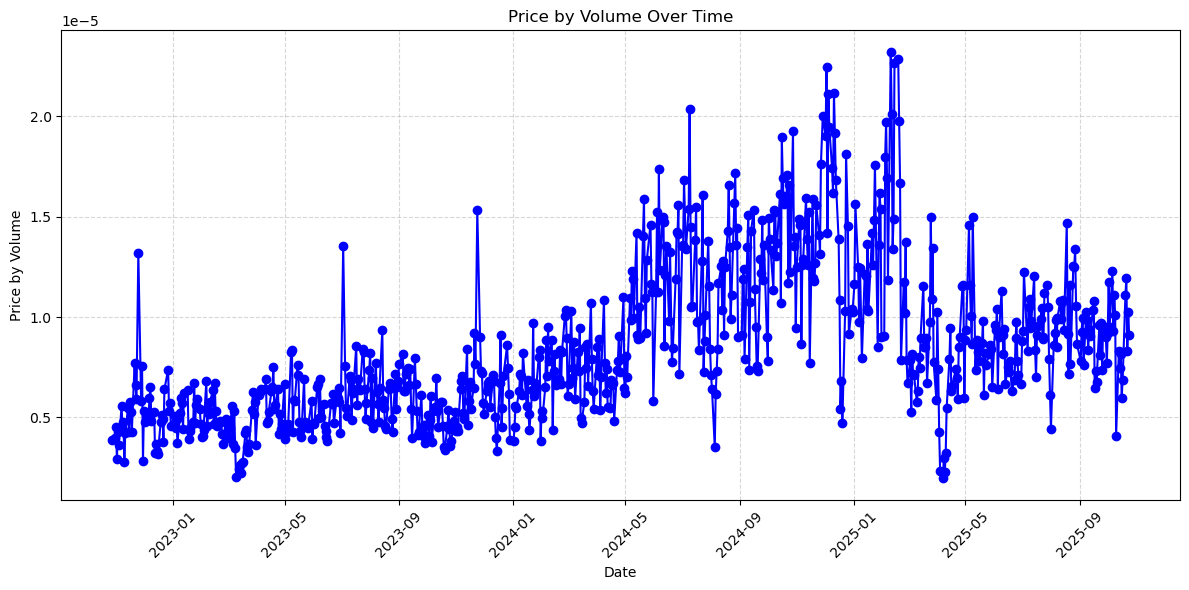

In [16]:
# Plot line graph
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['price by volume'], marker='o', linestyle='-', color='blue')
plt.xlabel('Date')
plt.ylabel('Price by Volume')
plt.title('Price by Volume Over Time')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

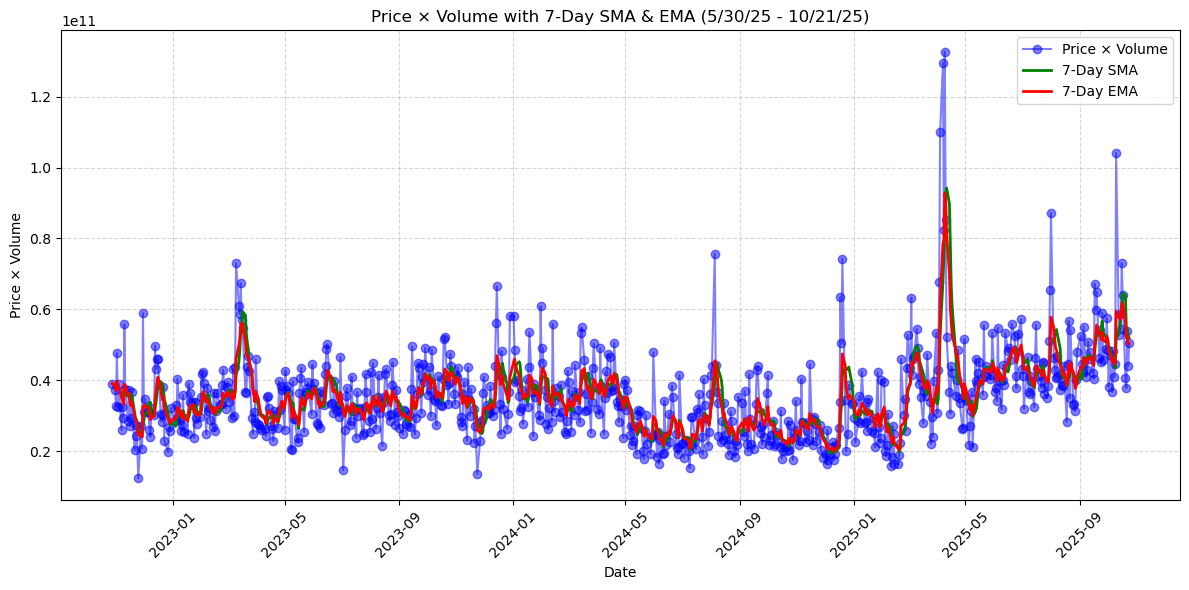

In [17]:
# Calculate Price × Volume
df['price by volume'] = df['close'] * df['volume']

# Calculate 7-day SMA
df['sma7'] = df['price by volume'].rolling(window=7).mean()

# Calculate 7-day EMA
df['ema7'] = df['price by volume'].ewm(span=7, adjust=False).mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['price by volume'], marker='o', linestyle='-', alpha=0.5, label='Price × Volume', color='blue')
plt.plot(df['date'], df['sma7'], color='green', linewidth=2, label='7-Day SMA')
plt.plot(df['date'], df['ema7'], color='red', linewidth=2, label='7-Day EMA')

plt.xlabel('Date')
plt.ylabel('Price × Volume')
plt.title('Price × Volume with 7-Day SMA & EMA (5/30/25 - 10/21/25)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Bullish SMA crossovers:
           date          sma7         sma30
717 2022-12-14  3.367804e+10  3.272397e+10
692 2023-01-23  3.272221e+10  3.222261e+10
689 2023-01-26  3.284280e+10  3.225088e+10
685 2023-02-01  3.163542e+10  3.057361e+10
670 2023-02-23  3.349833e+10  3.250570e+10
625 2023-04-28  3.356731e+10  3.309885e+10
611 2023-05-18  3.152792e+10  3.109691e+10
608 2023-05-23  3.253422e+10  3.203680e+10
593 2023-06-14  3.516661e+10  3.392054e+10
560 2023-08-02  3.311386e+10  3.207129e+10
550 2023-08-16  3.277519e+10  3.248074e+10
526 2023-09-20  3.351039e+10  3.279928e+10
505 2023-10-19  3.732038e+10  3.692426e+10
495 2023-11-02  4.036864e+10  3.934540e+10
471 2023-12-07  3.321190e+10  3.314236e+10
457 2023-12-28  3.417680e+10  3.399011e+10
434 2024-02-01  3.948458e+10  3.848341e+10
420 2024-02-22  3.753099e+10  3.675258e+10
409 2024-03-08  3.626378e+10  3.547413e+10
405 2024-03-14  3.699357e+10  3.522468e+10
395 2024-03-28  3.741017e+10  3.599647e+10
385 2024-04-12  3.902158e+10 

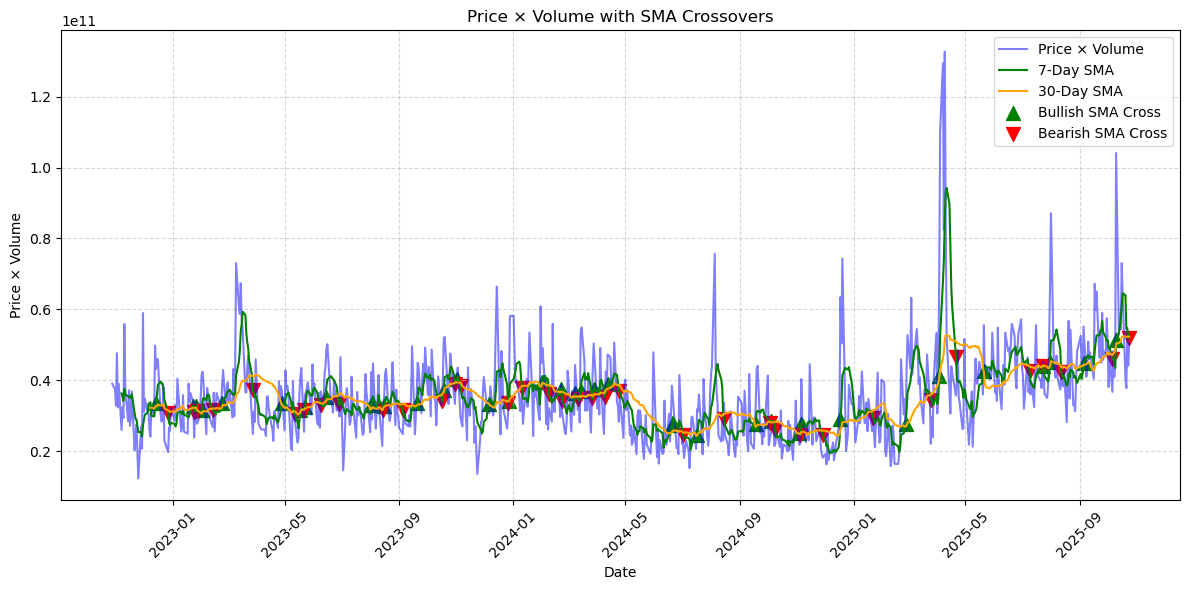

In [18]:
# Short-term and long-term SMAs
df['sma30'] = df['price by volume'].rolling(window=30).mean()

# Short-term and long-term EMAs
df['ema30'] = df['price by volume'].ewm(span=30, adjust=False).mean()

# Find crossover signals (SMA example)
df['sma_signal'] = np.where(df['sma7'] > df['sma30'], 1, 0)  # 1 = bullish, 0 = bearish
df['sma_crossover'] = df['sma_signal'].diff()  # 1 = buy, -1 = sell

# Find crossover signals (EMA example)
df['ema_signal'] = np.where(df['ema7'] > df['ema30'], 1, 0)
df['ema_crossover'] = df['ema_signal'].diff()

# Print crossover points
bullish_sma = df[df['sma_crossover'] == 1]
bearish_sma = df[df['sma_crossover'] == -1]

bullish_ema = df[df['ema_crossover'] == 1]
bearish_ema = df[df['ema_crossover'] == -1]

print("Bullish SMA crossovers:\n", bullish_sma[['date', 'sma7', 'sma30']])
print("Bearish SMA crossovers:\n", bearish_sma[['date', 'sma7', 'sma30']])
print("Bullish EMA crossovers:\n", bullish_ema[['date', 'ema7', 'ema30']])
print("Bearish EMA crossovers:\n", bearish_ema[['date', 'ema7', 'ema30']])

# Optional: plot SMA crossovers
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['price by volume'], color='blue', alpha=0.5, label='Price × Volume')
plt.plot(df['date'], df['sma7'], color='green', label='7-Day SMA')
plt.plot(df['date'], df['sma30'], color='orange', label='30-Day SMA')

# Mark bullish and bearish crossovers
plt.scatter(bullish_sma['date'], bullish_sma['sma7'], marker='^', color='g', s=100, label='Bullish SMA Cross')
plt.scatter(bearish_sma['date'], bearish_sma['sma7'], marker='v', color='r', s=100, label='Bearish SMA Cross')

plt.xlabel('Date')
plt.ylabel('Price × Volume')
plt.title('Price × Volume with SMA Crossovers')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

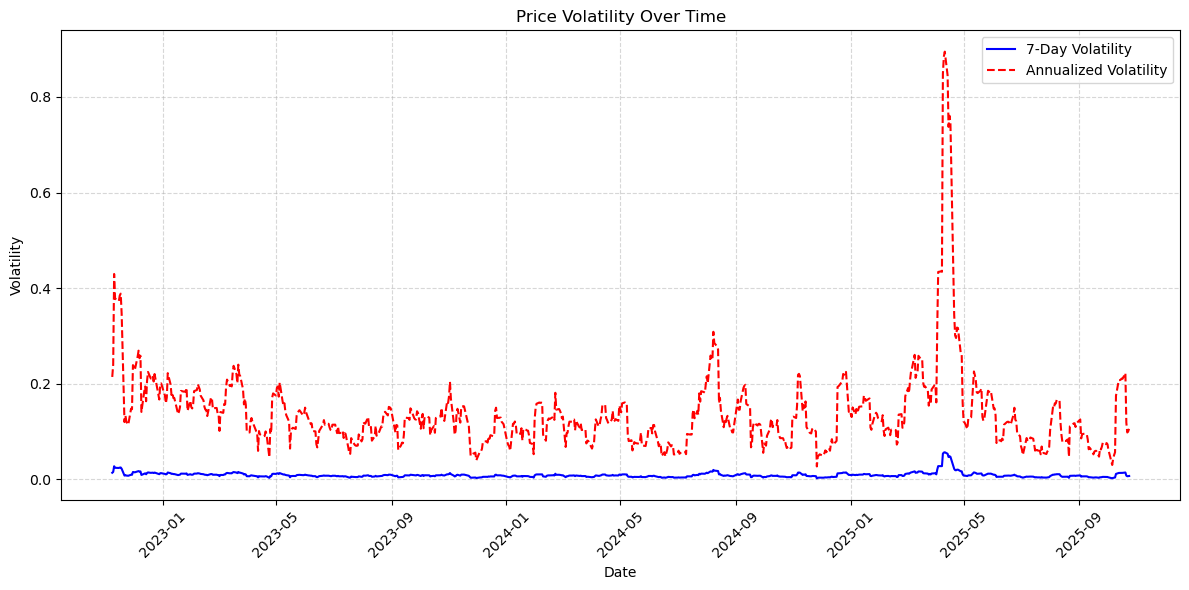

In [19]:
# Calculate daily returns
df['returns'] = df['close'].pct_change()

# Calculate rolling volatility (e.g., 7-day)
df['volatility_7d'] = df['returns'].rolling(window=7).std()

# Optional: annualized volatility (assuming 252 trading days)
df['volatility_annualized'] = df['volatility_7d'] * np.sqrt(252)

# Plot rolling volatility
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['volatility_7d'], label='7-Day Volatility', color='blue')
plt.plot(df['date'], df['volatility_annualized'], label='Annualized Volatility', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Price Volatility Over Time')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

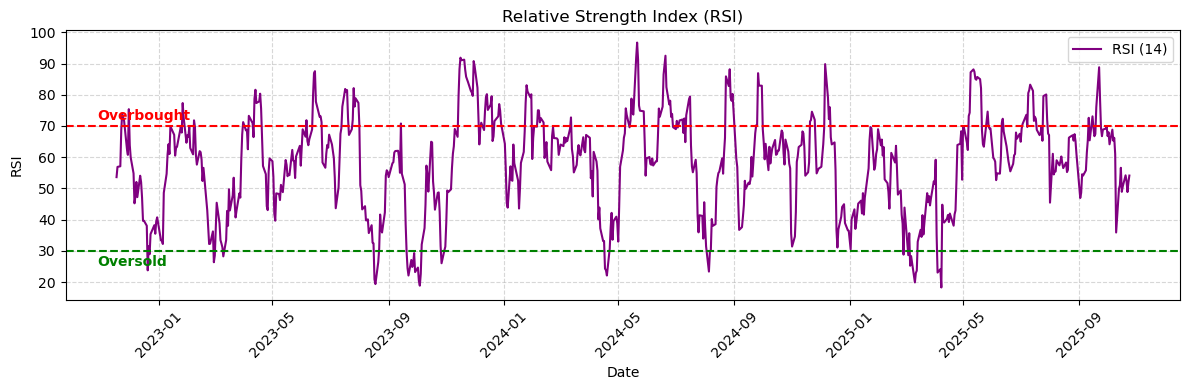

In [20]:
# Calculate daily returns
delta = df['close'].diff()

# Separate gains and losses
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

# Calculate average gain/loss
window = 14
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

# Calculate RS and RSI
rs = avg_gain / avg_loss
df['rsi'] = 100 - (100 / (1 + rs))

# Plot RSI
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['rsi'], color='purple', label='RSI (14)')
plt.axhline(70, color='red', linestyle='--')  # overbought
plt.axhline(30, color='green', linestyle='--')  # oversold
plt.text(df['date'].iloc[0], 70+2, 'Overbought', color='red', fontsize=10, fontweight='bold')
plt.text(df['date'].iloc[0], 30-5, 'Oversold', color='green', fontsize=10, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.title('Relative Strength Index (RSI)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

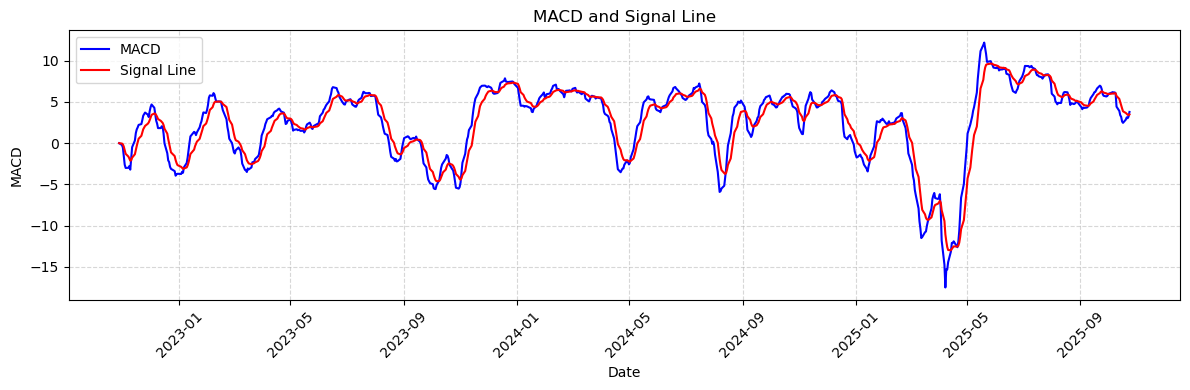

In [21]:
# Calculate MACD
ema12 = df['close'].ewm(span=12, adjust=False).mean()
ema26 = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = ema12 - ema26

# Signal line
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# Plot MACD
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['macd'], label='MACD', color='blue')
plt.plot(df['date'], df['macd_signal'], label='Signal Line', color='red')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.title('MACD and Signal Line')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'])

# Create day of week column (0=Monday, 6=Sunday)
df['day_of_week'] = df['date'].dt.dayofweek

# Create day-of-week one-hot
df = pd.concat([df, pd.get_dummies(df['day_of_week'], prefix='dow')], axis=1)

# Check which columns exist
print(df.filter(like='dow_').columns)

Index(['dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4'], dtype='object')


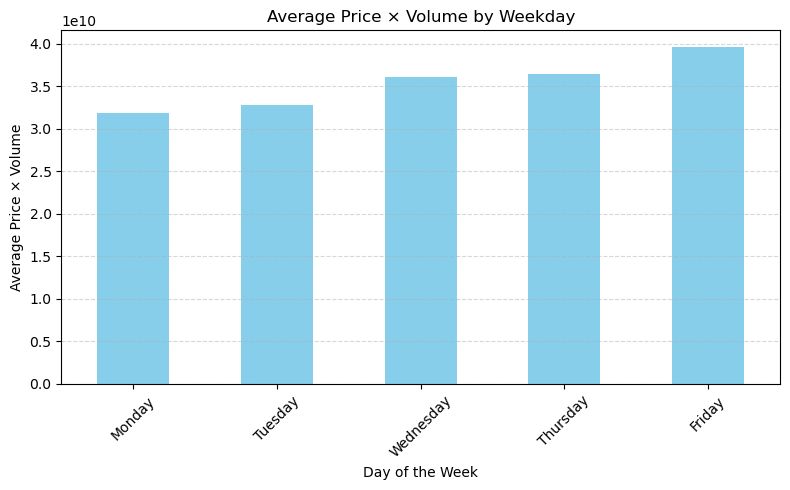

In [23]:
# Group by day_of_week and calculate average Price × Volume
avg_price_by_volume = df.groupby('day_of_week')['price by volume'].mean()

# Map day numbers to weekday names
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
avg_price_by_volume.index = avg_price_by_volume.index.map(weekday_names)

# Plot
plt.figure(figsize=(8,5))
avg_price_by_volume.plot(kind='bar', color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Average Price × Volume')
plt.title('Average Price × Volume by Weekday')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

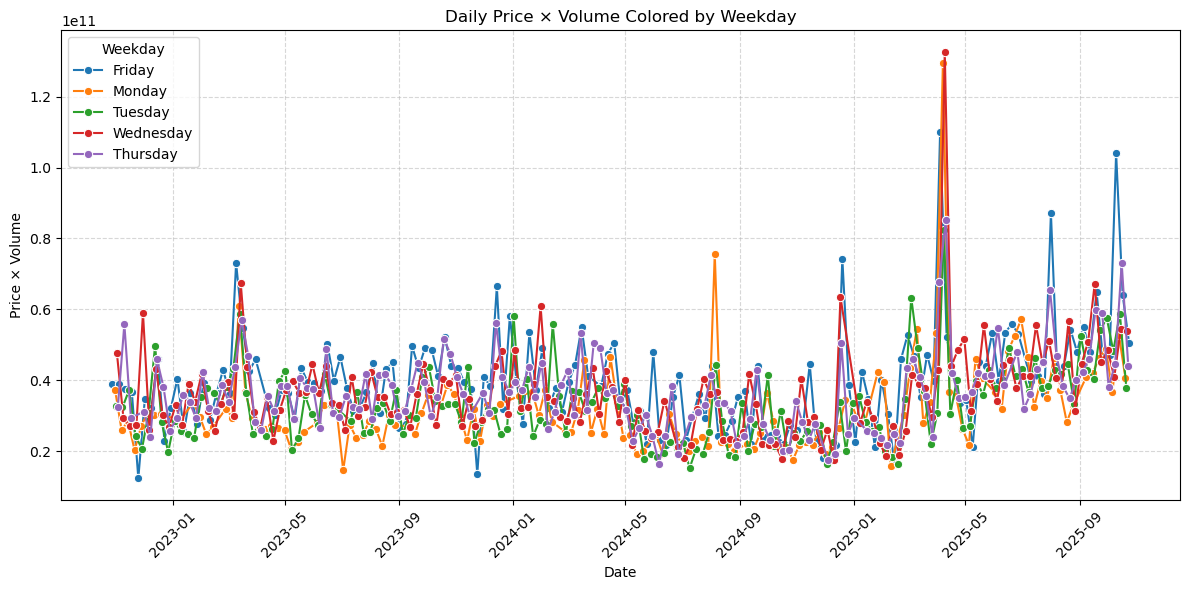

In [24]:
# Map numeric day_of_week to names
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
df['weekday_name'] = df['day_of_week'].map(weekday_names)

# Set a color palette for weekdays
palette = sns.color_palette("tab10", n_colors=5)  # 5 weekdays

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='date', y='price by volume', hue='weekday_name', palette=palette, marker='o')

plt.xlabel('Date')
plt.ylabel('Price × Volume')
plt.title('Daily Price × Volume Colored by Weekday')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Weekday')
plt.tight_layout()
plt.show()

In [25]:
#Average of close, volume by day of week
df.groupby('day_of_week')[['close', 'volume', 'price by volume']].mean()

,close,volume,price by volume
day_of_week,,,
0,514.437626,6.293870e+07,3.182698e+10
1,512.382645,6.547835e+07,3.279920e+10
2,511.105621,7.219346e+07,3.605547e+10
3,511.812067,7.313283e+07,3.647022e+10
4,511.904118,7.905845e+07,3.958424e+10


In [26]:
#Volatility by day of week
df.groupby('day_of_week')['log returns'].std()

day_of_week
0    0.008181
1    0.007980
2    0.012159
3    0.011213
4    0.010328
Name: log returns, dtype: float64

In [27]:
#Average daily return by day of week
df.groupby('day_of_week')['day to day'].mean()

day_of_week
0    1.107763
1    0.885774
2    0.472325
3    0.396227
4   -0.050757
Name: day to day, dtype: float64

In [28]:
#Which days have unusually high trading activity
threshold = df['volume'].mean() + df['volume'].std()
df[df['volume'] > threshold].groupby('day_of_week').size()

day_of_week
0     4
1    11
2    18
3    18
4    34
dtype: int64

In [29]:
#Correlation of pbv and daily by day of week
df.groupby('day_of_week')[['price by volume','day to day']].corr().iloc[0::2,-1]

day_of_week                 
0            price by volume   -0.345526
1            price by volume   -0.127002
2            price by volume    0.105424
3            price by volume   -0.012252
4            price by volume   -0.471663
Name: day to day, dtype: float64

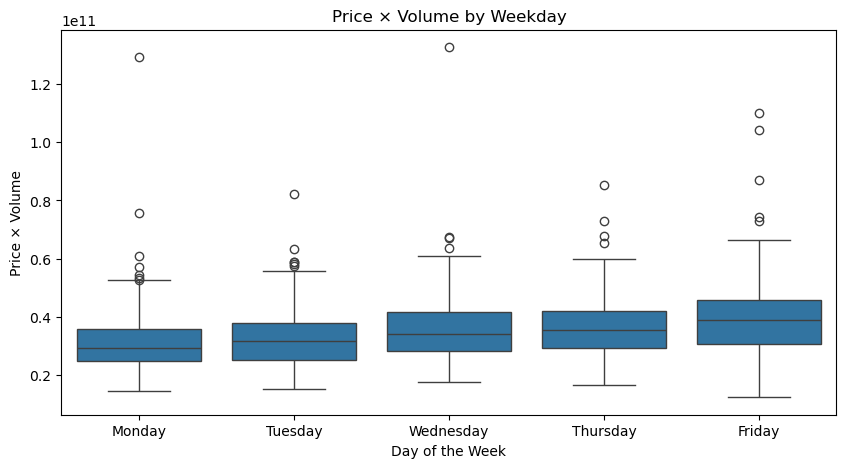

In [30]:
import seaborn as sns

# Define weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Boxplot with correct weekday order
plt.figure(figsize=(10,5))
sns.boxplot(x='weekday_name', y='price by volume', data=df, order=weekday_order)
plt.xlabel('Day of the Week')
plt.ylabel('Price × Volume')
plt.title('Price × Volume by Weekday')
plt.show()

In [31]:
# Overall skewness
print("Skewness of Price × Volume:", df['price by volume'].skew())
if df['price by volume'].skew() > 0:
    print('Skewed Right')
if df['price by volume'].skew() < 0:
    print('Skewed Left')
if df['price by volume'].skew() == 0:
    print('Roughly Symmetric')
print("Skewness of Volume:", df['volume'].skew())
if df['volume'].skew() > 0:
    print('Skewed Right')
if df['volume'].skew() < 0:
    print('Skewed Left')
if df['volume'].skew() == 0:
    print('Roughly Symmetric')
print("Skewness of Close:", df['close'].skew())
if df['close'].skew() > 0:
    print('Skewed Right')
if df['close'].skew() < 0:
    print('Skewed Left')
if df['close'].skew() == 0:
    print('Roughly Symmetric')

Skewness of Price × Volume: 2.226862230682544
Skewed Right
Skewness of Volume: 1.7218341381434963
Skewed Right
Skewness of Close: 0.06802260271658012
Skewed Right


In [32]:
# Skewness of Price × Volume by day of week
skew_by_day = df.groupby('day_of_week')['price by volume'].skew()

# Map numeric day to names for readability
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
skew_by_day.index = skew_by_day.index.map(weekday_names)

# Interpret skewness for each day
for day, skew in skew_by_day.items():
    if skew > 0:
        interpretation = 'Skewed Right: Investors should be aware of potential for extreme gains'
    elif skew < 0:
        interpretation = 'Skewed Left: Could indicate risk of sharp losses or market inactivity'
    else:
        interpretation = 'Roughly Symmetric: Daily price changes or trading volume are more predictable'
    print(f"{day}: {skew:.2f} → {interpretation}")

# Print the skew values as well
print("\nSkewness values by day:")
print(skew_by_day)

Monday: 3.76 → Skewed Right: Investors should be aware of potential for extreme gains
Tuesday: 1.16 → Skewed Right: Investors should be aware of potential for extreme gains
Wednesday: 3.13 → Skewed Right: Investors should be aware of potential for extreme gains
Thursday: 1.16 → Skewed Right: Investors should be aware of potential for extreme gains
Friday: 1.68 → Skewed Right: Investors should be aware of potential for extreme gains

Skewness values by day:
day_of_week
Monday       3.758964
Tuesday      1.162743
Wednesday    3.125193
Thursday     1.157460
Friday       1.675874
Name: price by volume, dtype: float64


In [33]:
from sklearn.preprocessing import MinMaxScaler

# Drop rows with NaNs in essential columns
df = df.dropna(subset=['open', 'high', 'low', 'close', 'volume'])

# Initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale only the OHLCV columns (exclude 'date')
scaled_features = scaler.fit_transform(df[['open', 'high', 'low', 'close', 'volume']])

# Create a new DataFrame with scaled features
scaled_df = pd.DataFrame(scaled_features, columns=['open', 'high', 'low', 'close', 'volume'])

# Add the date column back
scaled_df['date'] = df['date'].values

# Preview
print(scaled_df.head())

       open      high       low     close    volume       date
0  0.027558  0.050350  0.035488  0.058810  0.322052 2022-10-28
1  0.049099  0.046669  0.053673  0.049634  0.306132 2022-10-31
2  0.061231  0.053209  0.047253  0.044116  0.257452 2022-11-01
3  0.040771  0.047425  0.019455  0.012604  0.437806 2022-11-02
4  0.000000  0.000000  0.000000  0.000000  0.264793 2022-11-03


In [34]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Prepare data
# Features: OHLCV
features = ['open','high','low','close','volume']
# Set the sequence length
seq_length = 10

# Extract values and dates
X_data = scaled_df[features].values.astype(np.float32)
if 'date' in scaled_df.columns:
    dates = scaled_df['date'].values
else:
    dates = scaled_df.index.values

In [35]:
from sklearn.model_selection import train_test_split

# Convert the scaled DataFrame to a numpy array
data_values = scaled_df[['open', 'high', 'low', 'close', 'volume']].values

# Also get the dates as a separate array
dates = scaled_df['date'].values

# Define a function to create sequences of data for LSTM
def create_sequences(data_array, seq_length, date_array):
    xs, ys = [], []
    y_dates = []
    for i in range(len(data_array) - seq_length):
        x_seq = data_array[i: i + seq_length]
        y_val = data_array[i + seq_length][3]  # index 3 => 'close' column
        xs.append(x_seq)
        ys.append(y_val)
        # The date that corresponds to this y_val
        y_dates.append(date_array[i + seq_length])
    return np.array(xs), np.array(ys), np.array(y_dates)


# Set the sequence length
seq_length = 30

# Create sequences (features, targets, and corresponding dates)
X, y, y_dates = create_sequences(data_values, seq_length, dates)

# Maintains temporal order
split_idx = int(0.8 * len(X))

X_train = X[:split_idx]
X_test = X[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]
y_dates_train = y_dates[:split_idx]
y_dates_test = y_dates[split_idx:]

print(f"Training dates: {y_dates_train[0]} to {y_dates_train[-1]}")
print(f"Testing dates: {y_dates_test[0]} to {y_dates_test[-1]}")

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Print shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Training dates: 2022-12-12T00:00:00.000000000 to 2025-03-31T00:00:00.000000000
Testing dates: 2025-04-01T00:00:00.000000000 to 2025-10-24T00:00:00.000000000
X_train shape: torch.Size([576, 30, 5])
X_test shape: torch.Size([144, 30, 5])
y_train shape: torch.Size([576])
y_test shape: torch.Size([144])


In [36]:
# Model architecture
class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, output_size=1, num_layers=2):
        super(ImprovedLSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers,
            batch_first=True,
            dropout=0.4 if num_layers > 1 else 0
        )
        
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

def get_device():
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("🚀 Using Apple Silicon GPU (MPS)")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"🚀 Using CUDA GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("⚠️  Using CPU")
    return device

In [37]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Parameters
input_size = 5
hidden_layer_size = 64
output_size = 1
learning_rate = 0.0005
num_epochs = 200
batch_size = 64
patience = 20

# Initialize model
model = ImprovedLSTMModel(input_size, hidden_layer_size, output_size)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=5)

# Get device
device = get_device()
model = model.to(device)

# Move data to device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Create dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training loop 
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

print(f"\n{'='*60}")
print("TRAINING")
print(f"{'='*60}")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_function(y_pred.squeeze(), y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            loss = loss_function(y_pred.squeeze(), y_batch)
            val_loss += loss.item()
    
    # Calculate average losses
    avg_train = train_loss / len(train_loader)
    avg_val = val_loss / len(test_loader)
    
    train_losses.append(avg_train)
    val_losses.append(avg_val)
    
    # Learning rate scheduling
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_val)
    new_lr = optimizer.param_groups[0]['lr']
    
    if old_lr != new_lr:
        print(f"  → Learning rate reduced: {old_lr:.6f} -> {new_lr:.6f}")
    
    # Early stopping with best model saving
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        patience_counter = 0
        torch.save(model.state_dict(), 'lstm_model_best.pth')
    else:
        patience_counter += 1
    
    # Print progress
    if epoch % 10 == 0:
        status = "✓" if avg_val == best_val_loss else ""
        print(f"Epoch {epoch:3d} - Train: {avg_train:.6f}, Val: {avg_val:.6f} {status}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\n⚠️ Early stopping at epoch {epoch}")
        break

print(f"\n✓ Training complete! Best Val Loss: {best_val_loss:.6f}")

# Load best model
model.load_state_dict(torch.load('lstm_model_best.pth'))

🚀 Using Apple Silicon GPU (MPS)

TRAINING
Epoch   0 - Train: 0.106259, Val: 0.395490 ✓
Epoch  10 - Train: 0.009717, Val: 0.036026 
  → Learning rate reduced: 0.000500 -> 0.000150
  → Learning rate reduced: 0.000150 -> 0.000045
Epoch  20 - Train: 0.007702, Val: 0.035198 
  → Learning rate reduced: 0.000045 -> 0.000013

⚠️ Early stopping at epoch 26

✓ Training complete! Best Val Loss: 0.012367


<All keys matched successfully>


PyTorch LSTM Test Metrics:
MSE:  646.7103
RMSE: 25.4305
MAE:  19.0037
MAPE: 3.12%


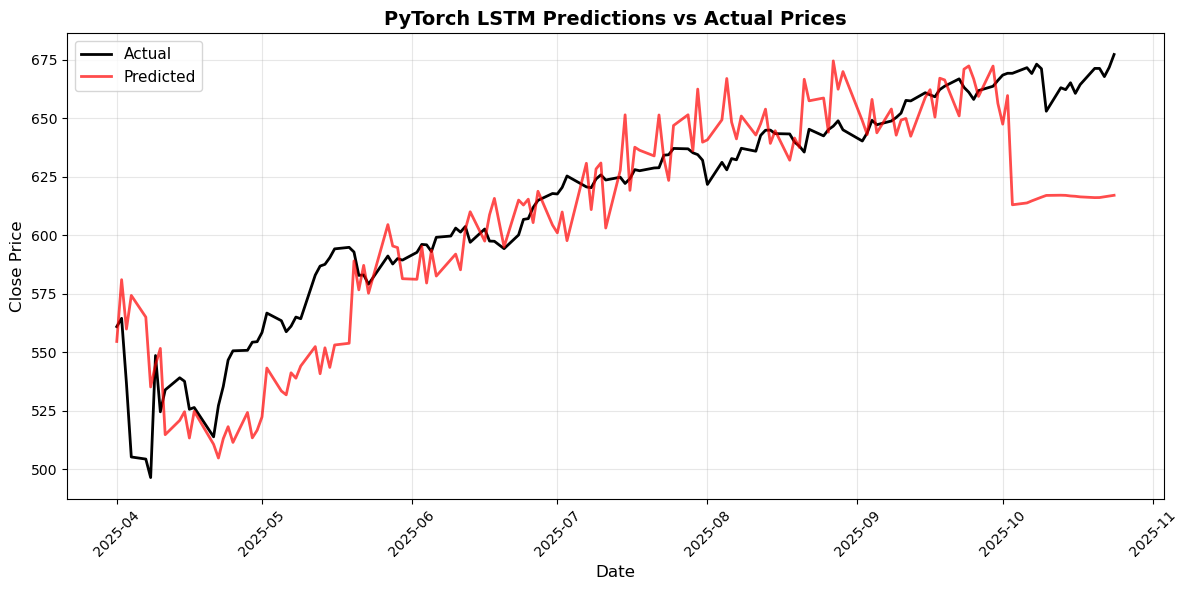

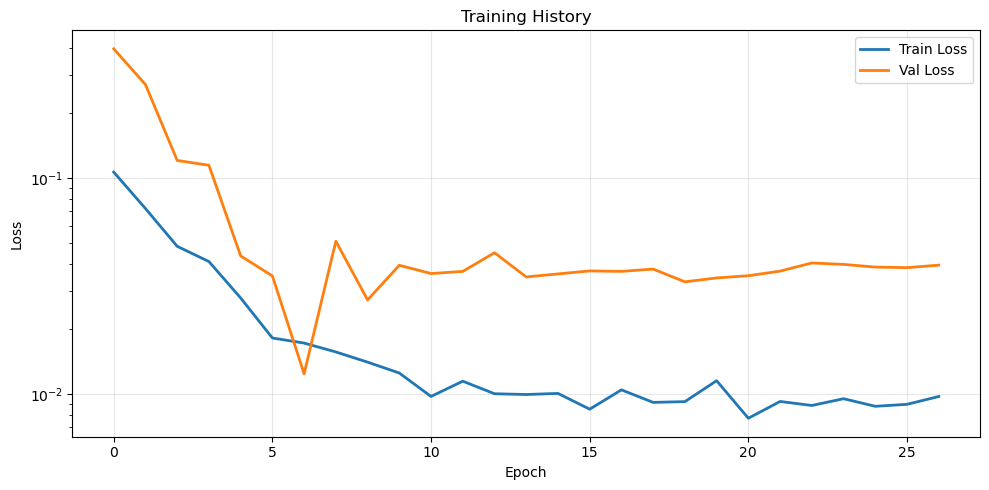

In [38]:
# Make predictions on the test set
model.eval()
test_predictions = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        preds = model(X_batch)
        test_predictions.extend(preds.squeeze().cpu().numpy())

test_predictions = np.array(test_predictions)
y_test_np = y_test.cpu().numpy()

# Invert scaling to get actual prices
close_idx = 3  # 'close' column index

# Recreate scaler for inverse transform
scaler_inverse = MinMaxScaler(feature_range=(0, 1))
scaler_inverse.fit(df[features])

# Predictions
test_preds_reshaped = np.zeros((len(test_predictions), len(features)))
test_preds_reshaped[:, close_idx] = test_predictions
test_predictions_inverted = scaler_inverse.inverse_transform(test_preds_reshaped)[:, close_idx]

# True values
y_test_reshaped = np.zeros((len(y_test_np), len(features)))
y_test_reshaped[:, close_idx] = y_test_np
y_test_inverted = scaler_inverse.inverse_transform(y_test_reshaped)[:, close_idx]

# Dates
dates_test_plot = y_dates_test[:len(test_predictions_inverted)]


# Metrics
mse = mean_squared_error(y_test_inverted, test_predictions_inverted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inverted, test_predictions_inverted)
mape = np.mean(np.abs((y_test_inverted - test_predictions_inverted) / y_test_inverted)) * 100

print(f"\n{'='*60}")
print("PyTorch LSTM Test Metrics:")
print(f"{'='*60}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"{'='*60}")


# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(dates_test_plot, y_test_inverted, label='Actual', color='black', linewidth=2)
plt.plot(dates_test_plot, test_predictions_inverted, label='Predicted', color='red', alpha=0.7, linewidth=2)
plt.title('PyTorch LSTM Predictions vs Actual Prices', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

In [39]:
print(f"Final Train Loss: {train_losses[-1]:.6f}")
print(f"Final Val Loss: {val_losses[-1]:.6f}")
print(f"Ratio: {train_losses[-1] / val_losses[-1]:.2f}")

# If ratio is:
# 0.5-0.8: Perfectly fine
# 0.3-0.5: Acceptable (some overfitting but performing well)
# < 0.3: Significant overfitting (but if test metrics are good, who cares!)

Final Train Loss: 0.009713
Final Val Loss: 0.039403
Ratio: 0.25
